# Barotropic and Overturning circulation in the cavity vs mean melt rate

Nicolas Jourdain (IGE, CNRS)

ISOMIP+

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob

In [2]:
datadir='/Users/nicolasjourdain/DATA_ISOMIP'
model = sorted(glob.glob('[A-Z]*',root_dir=datadir))
Nmod=np.shape(model)[0]
print(model)

['COCO', 'FVCOM', 'MITgcm_BAS', 'MITgcm_BAS_Coupled', 'MITgcm_JPL', 'MOM6', 'MOM6_SIGMA_ZSTAR', 'MPAS-Ocean', 'NEMO-CNRS', 'NEMO-UKESM1is', 'POP2x', 'ROMSUTAS']


#### Calculating the melt rates and circulation metrics for individual models :

In [3]:
mlt1=np.zeros((Nmod,240))
mlt2=np.zeros((Nmod,240))
bsf1=np.zeros((Nmod,240))
bsf2=np.zeros((Nmod,240))
ovt1=np.zeros((Nmod,240))
ovt2=np.zeros((Nmod,240))

for kmod in np.arange(Nmod):
    oce1=xr.open_dataset(datadir+'/'+model[kmod]+'/Ocean0-2 COM/Ocean1_COM_'+model[kmod]+'.nc',decode_times=False)
    oce2=xr.open_dataset(datadir+'/'+model[kmod]+'/Ocean0-2 COM/Ocean2_COM_'+model[kmod]+'.nc',decode_times=False)
    # mean melt rate (m/yr):
    mlt1[kmod,:]=oce1.meanMeltRate.isel(nTime=slice(0,240)).values*86400*365.25
    mlt2[kmod,:]=oce2.meanMeltRate.isel(nTime=slice(0,240)).values*86400*365.25
    # Amplitude of the barotropic streamfuction in the cavity (Sv):
    # (calving front at x=650km, i.e. nx's 159th index)
    tmp1=oce1.barotropicStreamfunction.where(((oce1.barotropicStreamfunction < 1.e36) & (abs(oce1.iceDraft) > 50.)))
    bsf1[kmod,:]=(tmp1.isel(nx=slice(0,159)).max(dim=["nx", "ny"])-tmp1.isel(nx=slice(0,159)).min(dim=["nx", "ny"])).isel(nTime=slice(0,240)).values*1.e-6
    tmp2=oce2.barotropicStreamfunction.where(((oce2.barotropicStreamfunction < 1.e36) & (abs(oce2.iceDraft) > 50.)))
    bsf2[kmod,:]=(tmp2.isel(nx=slice(0,159)).max(dim=["nx", "ny"])-tmp2.isel(nx=slice(0,159)).min(dim=["nx", "ny"])).isel(nTime=slice(0,240)).values*1.e-6
    # Amplitude of the overturning streamfunction in the cavity (Sv):
    # (calving front at x=650km, i.e. nx's 159th index)
    tmp3=oce1.overturningStreamfunction.where((oce1.overturningStreamfunction < 1.e36))
    ovt1[kmod,:]=(tmp3.isel(nx=slice(0,159)).max(dim=["nx", "nz"])-tmp3.isel(nx=slice(0,159)).min(dim=["nx", "nz"])).isel(nTime=slice(0,240)).values*1.e-6
    tmp4=oce2.overturningStreamfunction.where((oce2.overturningStreamfunction < 1.e36))
    ovt2[kmod,:]=(tmp4.isel(nx=slice(0,159)).max(dim=["nx", "nz"])-tmp4.isel(nx=slice(0,159)).min(dim=["nx", "nz"])).isel(nTime=slice(0,240)).values*1.e-6

#### Prepare data for linear interpolation (excluding outliers):

In [4]:
excluded_models=['COCO','MITgcm_BAS_Coupled']
indx=np.array([]).astype('int')
for kmod in np.arange(0,Nmod):
    ok=True
    for modexc in excluded_models:
        if ( model[kmod] == modexc ):
            ok=False
    if ok:
        indx=np.append(indx,[kmod]) # list of indices of models that are kept

M1=np.reshape(mlt1[indx,:],-1).squeeze()
M2=np.reshape(mlt2[indx,:],-1).squeeze()
B1=np.reshape(bsf1[indx,:],-1).squeeze()
B2=np.reshape(bsf2[indx,:],-1).squeeze()
O1=np.reshape(ovt1[indx,:],-1).squeeze()
O2=np.reshape(ovt2[indx,:],-1).squeeze()

a=np.zeros((4))
b=np.zeros((4))
a[0],b[0] = np.polyfit(M1,B1,1)
a[1],b[1] = np.polyfit(M2,B2,1)
a[2],b[2] = np.polyfit(M1,O1,1)
a[3],b[3] = np.polyfit(M2,O2,1)

#### Scatter plots:

11.276057877642375
24.46496171943139
52.85286190138976
50.98091071346324


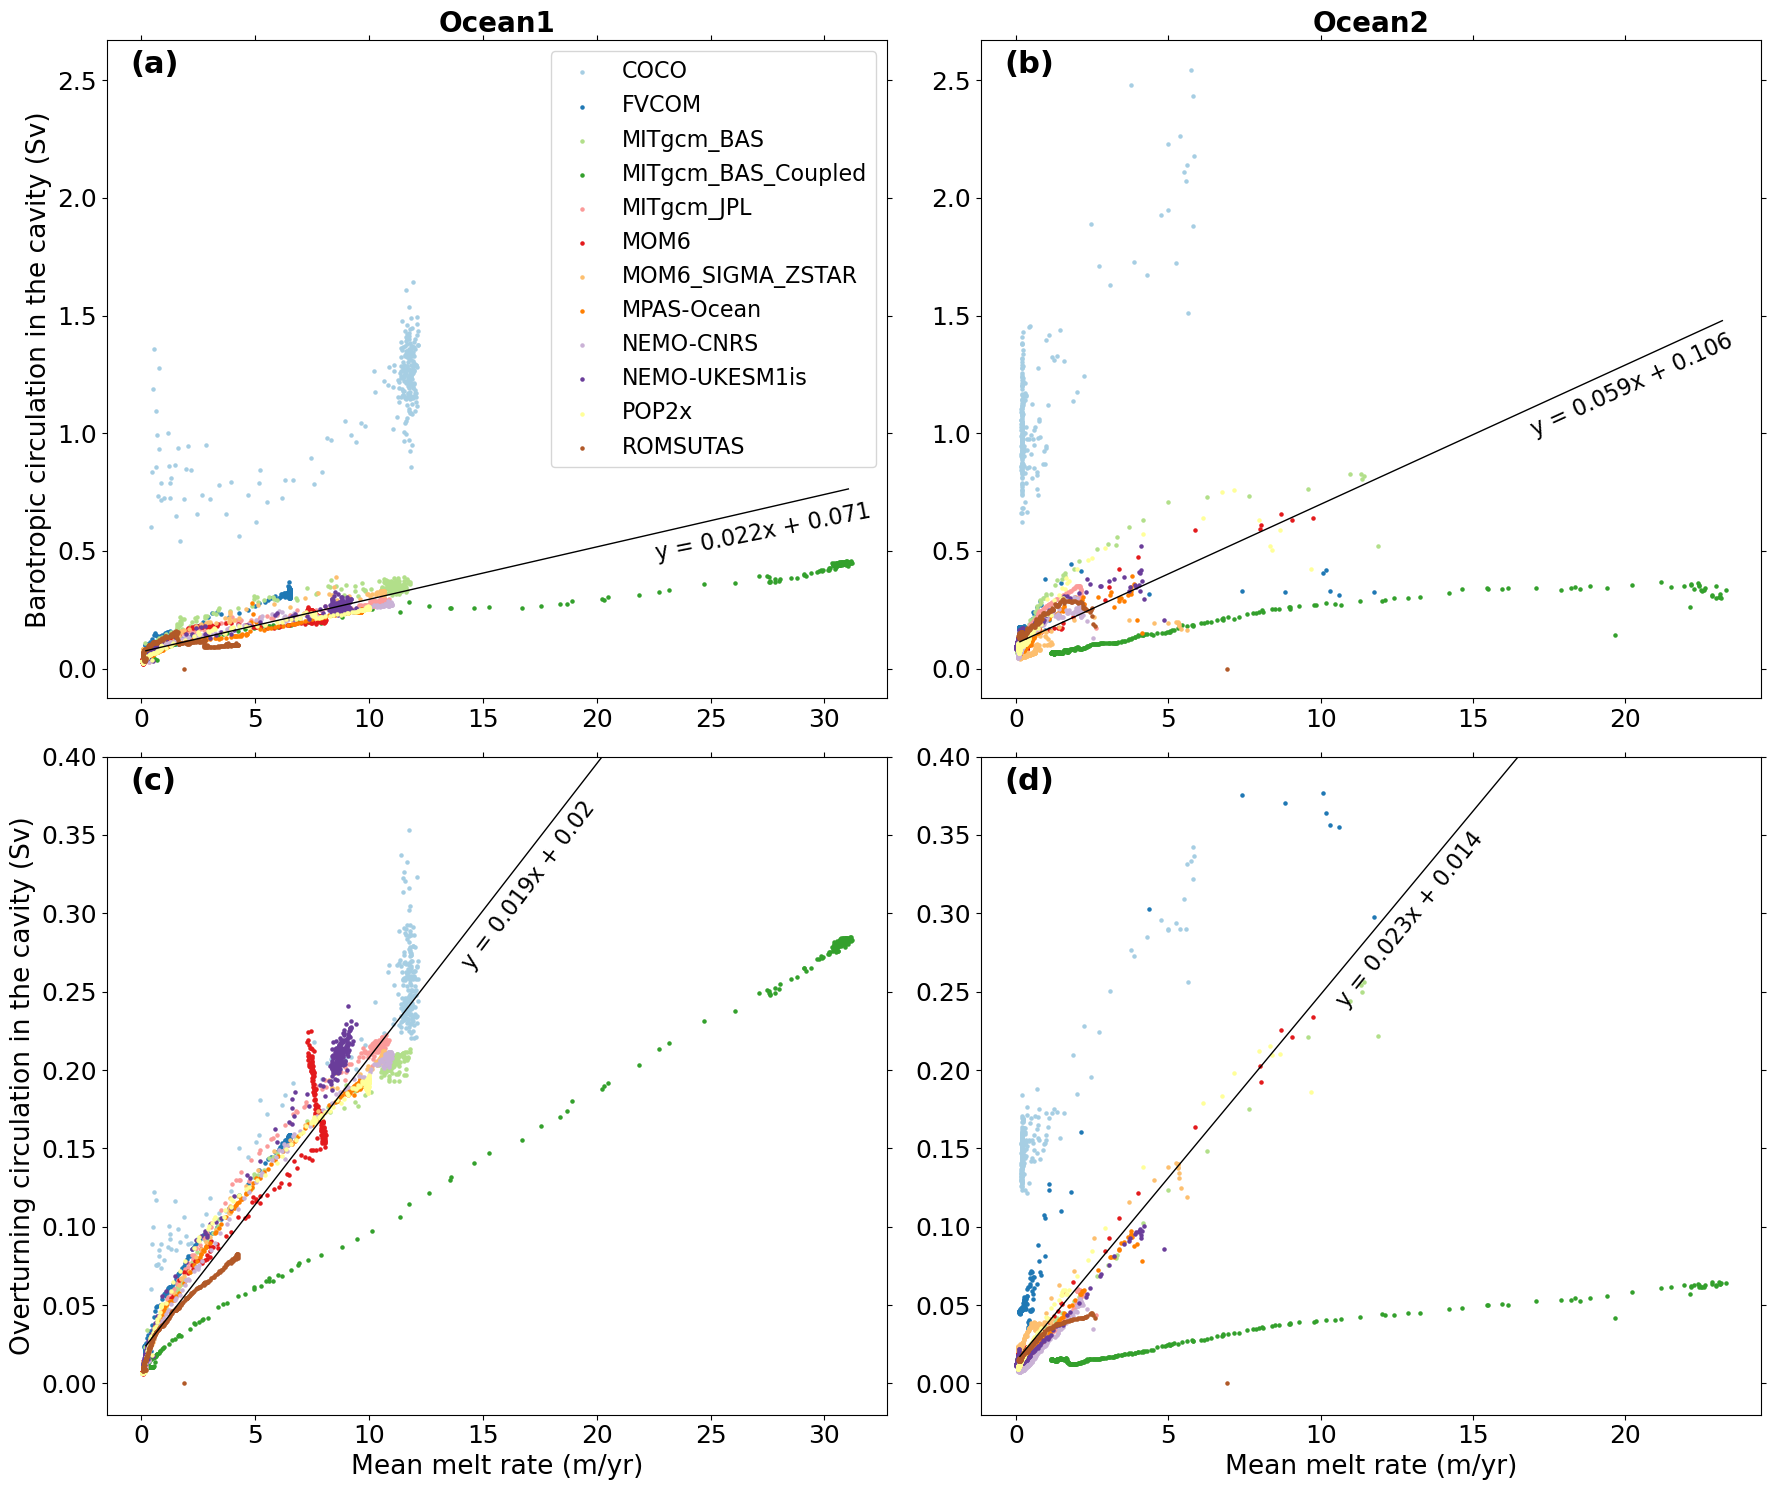

In [41]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(18.0,15.0))
axs = axs.ravel()

modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# Main scatter plot:
for kmod in np.arange(Nmod):
    
    axs[0].scatter(mlt1[kmod,:],bsf1[kmod,:],s=5,c=modelcolours[kmod],label=model[kmod])
    axs[1].scatter(mlt2[kmod,:],bsf2[kmod,:],s=5,c=modelcolours[kmod])
    axs[2].scatter(mlt1[kmod,:],ovt1[kmod,:],s=5,c=modelcolours[kmod])
    axs[3].scatter(mlt2[kmod,:],ovt2[kmod,:],s=5,c=modelcolours[kmod])
    
axs[0].legend(fontsize=16)

# Customization:
axs[0].set_title('Ocean1',fontsize=20,fontweight='bold')
axs[0].set_ylabel('Barotropic circulation in the cavity (Sv)',fontsize=19)
    
axs[1].set_title('Ocean2',fontsize=20,fontweight='bold')
axs[1].sharey(axs[0])
    
axs[2].set_ylim(-0.02,0.40)    
axs[2].sharex(axs[0])
axs[2].set_xlabel('Mean melt rate (m/yr)',fontsize=19)
axs[2].set_ylabel('Overturning circulation in the cavity (Sv)',fontsize=19)
    
axs[3].sharey(axs[2])
axs[3].sharex(axs[1])
axs[3].set_xlabel('Mean melt rate (m/yr)',fontsize=19)

alphabet=['(a)','(b)','(c)','(d)']
for kk in np.arange(4):

    # Attribute letters to individual panels:
    axs[kk].tick_params(labelsize=18,right=True,top=True)
    [xmin, xmax]=axs[kk].get_xlim()
    [ymin, ymax]=axs[kk].get_ylim()
    axs[kk].text(xmin+0.03*(xmax-xmin),ymax-0.05*(ymax-ymin),alphabet[kk],fontsize=22,fontweight='bold')

    # Linear regressions:
    xx=np.array([xmin+0.05*(xmax-xmin),xmax-0.05*(xmax-xmin)])
    axs[kk].plot(xx,a[kk]*xx+b[kk],'k',linewidth=1)
    ang=np.arctan(a[kk]/axs[kk].get_data_ratio())*180./np.pi-4
    if ( kk <= 1 ):
        xtmp=xmax-0.3*(xmax-xmin)
    else:
        xtmp=xmax-0.55*(xmax-xmin)
    ytmp=xtmp*a[kk]+b[kk]
    lab='y = '+np.round(a[kk],3).astype('str')+'x + '+np.round(b[kk],3).astype('str')
    axs[kk].text(xtmp,ytmp-0.04*(ymax-ymin),lab,rotation=ang,fontsize=16)
    
fig.tight_layout()

In [42]:
figname='circulation_vs_melt_Ocean12.pdf'

fig.savefig(figname)